## Kaggle - Time Series Analysis
Data Obtained from Wal-Mart w/ 5 years of store-item sales data

**Goal**: Predict 3 months of sales for 50 different items at 10 different stores

In [1]:
# Dependencies
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'sample_submission.csv',
 'test.csv',
 'train.csv',
 'Untitled.ipynb']

In [3]:
df=pd.read_csv('train.csv')
print(f'{len(df)} records')
print(f'{len(df["store"].unique())} stores')
print(f'{len(df["date"].unique())} days')
print(f'{len(df["item"].unique())} items')
# df['store'].unique()
# df.head(100)

913000 records
10 stores
1826 days
50 items


In [4]:
df['date']=pd.to_datetime(df['date'])

In [5]:
df['month']=df['date'].map(lambda x: f'{x.year}-{("0"+str(x.month))[-2:]}')
# df['month']=pd.to_datetime(df['month'])
df['year']=df['date'].map(lambda x: f'{x.year}')
# df['year']=pd.to_datetime(df['year'])
df.head(100)

,date,store,item,sales,month,year
0,2013-01-01,1,1,13,2013-01,2013
1,2013-01-02,1,1,11,2013-01,2013
2,2013-01-03,1,1,14,2013-01,2013
3,2013-01-04,1,1,13,2013-01,2013
4,2013-01-05,1,1,10,2013-01,2013
...,...,...,...,...,...,...
95,2013-04-06,1,1,23,2013-04,2013
96,2013-04-07,1,1,17,2013-04,2013
97,2013-04-08,1,1,19,2013-04,2013
98,2013-04-09,1,1,13,2013-04,2013


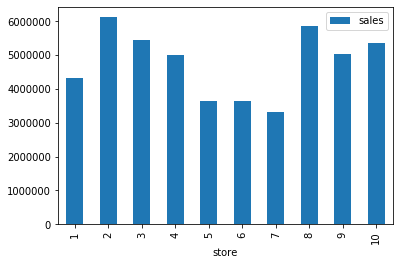

In [6]:
store_sales=pd.DataFrame(df.groupby('store')['sales'].sum()).plot(kind='bar')

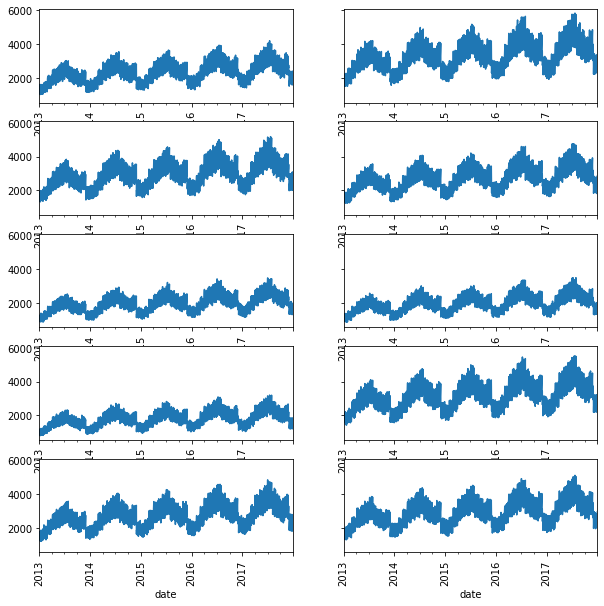

In [7]:
stores_trend=df.pivot_table(index='date', values='sales', columns='store', aggfunc='sum')
all_stores=stores_trend.columns
fig, ax=plt.subplots(5, 2, figsize=(10, 10), sharey=True)
for idx, each_store in enumerate(all_stores): 
    stores_trend[each_store].plot(ax=ax[int(idx/2)][idx%2], rot=90)

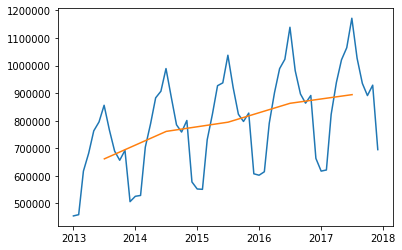

In [8]:
monthly_sales=df.sort_values('date').groupby('month')['sales'].sum().reset_index()
monthly_sales['month']=pd.to_datetime(monthly_sales['month'], format='%Y-%m')
monthly_sales['year']=monthly_sales['month'].map(lambda x: x.year)
yearly_sales=monthly_sales.groupby('year')['sales'].mean().reset_index()
yearly_sales['year']=pd.to_datetime(yearly_sales['year'], format='%Y')
plt.plot(monthly_sales['month'], monthly_sales['sales'])
plt.plot(yearly_sales['year']+datetime.timedelta(6*365/12), yearly_sales['sales'])
plt.show()

### This series is not stationary, which violates the regression assumption. A stationary series is one which: 
* mean, variance, and covariance do not vary with time
![stationary](https://github.com/kevinclee26/time_series_analysis/blob/main/assets/images/image_1.PNG?raw=true)
* use differencing to make series stationary as it is required for time series forecasting models
    * another option would be transformation - power transform, log transform, and square root

### Covariance and Correlation
* Std is a measure of dispersion of a distribution - low Std indicates that values tend to be close to the mean
![stationary](https://github.com/kevinclee26/time_series_analysis/blob/main/assets/images/image_3.PNG?raw=true)    
* Covariance can be negative infinity to positive infinity - it measure how two variables change together, not the dependency
    * Since magnitude can vary with the scaling of the variables - it is only useful to find the direction of the relationship between two variables
![stationary](https://github.com/kevinclee26/time_series_analysis/blob/main/assets/images/image_2.PNG?raw=true)    
* Correlation measures the strength of a relationship between two variables - shows direction and magnitude (can be -1 to +1)
![stationary](https://github.com/kevinclee26/time_series_analysis/blob/main/assets/images/image_4.PNG?raw=true)    

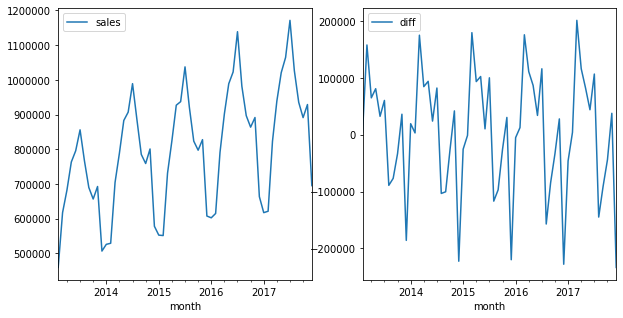

In [9]:
monthly_sales['diff']=monthly_sales['sales'].diff()
monthly_sales.dropna(inplace=True)
monthly_sales
fig, ax=plt.subplots(1, 2, figsize=(10, 5))
monthly_sales.plot(x='month', y='sales', ax=ax[0])
monthly_sales.plot(x='month', y='diff', ax=ax[1])

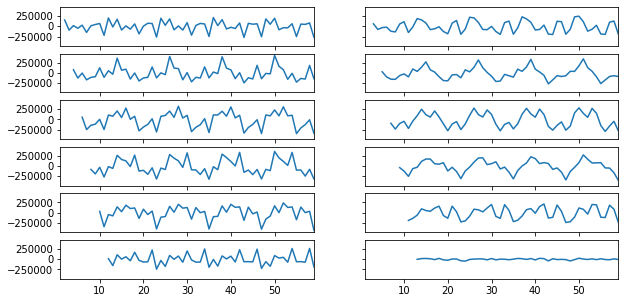

In [10]:
fig, ax=plt.subplots(6, 2, figsize=(10, 5), sharex=True, sharey=True)
for each_lag in range(12):
    monthly_sales['diff'].diff(each_lag+1).plot(ax=ax[int(each_lag/2)][each_lag%2])

### Time Series Forecast
1. ARIMA - autoregressive integrated moving average
    * the information in the past values of the time series can alone be used to predict the future values
    * p - order of the AR term
    * d - number of differencing required to make the time series stationary
    * q - order of the MA term
    * use autocorrelation and partial autocorrelation plots to decide the number of lags

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


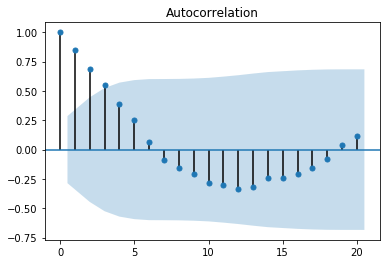

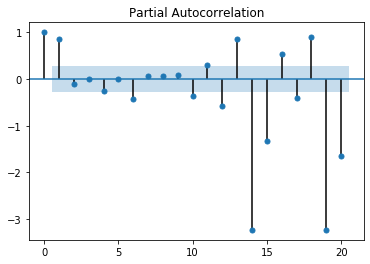

In [11]:
import statsmodels.tsa.api as smt
smt.graphics.plot_acf(monthly_sales['sales'].diff(12).dropna(), lags=20)
smt.graphics.plot_pacf(monthly_sales['sales'].diff(12).dropna(), lags=20)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


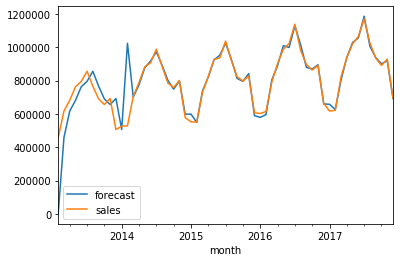

In [16]:
arima_model=smt.statespace.SARIMAX(monthly_sales['sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
arima_model_fit=arima_model.fit()
monthly_sales['forecast']=arima_model_fit.predict()
monthly_sales.set_index('month')[['forecast', 'sales']].plot()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RMSE: 124380.49117151636 MAE: 85485.4781747509 R2: 0.4455112346745981
RMSE: 120493.25252847448 MAE: 88859.78243343343 R2: 0.47962829791640693


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa

RMSE: 127690.98843481456 MAE: 87510.62612501952 R2: 0.4156020096622476
RMSE: 108233.56343018322 MAE: 78868.25731738245 R2: 0.5801326243433287
RMSE: 129670.16323184072 MAE: 93699.23325960411 R2: 0.39734560054430845


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


RMSE: 93247.38665568261 MAE: 48319.08150038107 R2: 0.6883540018256342
RMSE: 128239.90669974311 MAE: 95397.02590198988 R2: 0.41056678777023914


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespa

RMSE: 112281.49952171098 MAE: 82239.23599157094 R2: 0.5481392443600177
RMSE: 133376.94035768442 MAE: 94613.3672089303 R2: 0.36239793146271815


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.

RMSE: 130606.0544762633 MAE: 92752.06334697672 R2: 0.3886149202032836
RMSE: 151613.90025607697 MAE: 107850.78110212162 R2: 0.17611564423212223


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RMSE: 97349.80274749907 MAE: 40133.225574507815 R2: 0.6603290796408692


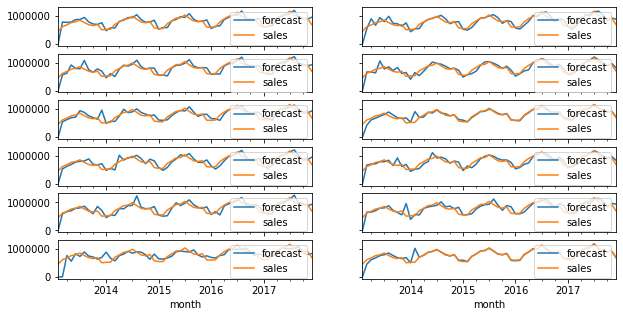

In [25]:
fig, ax=plt.subplots(6, 2, figsize=(10, 5), sharey=True, sharex=True)
for idx, each_period in enumerate(range(1, 13)):
    model=smt.statespace.SARIMAX(monthly_sales['sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, each_period))
    model_fit=model.fit()
    monthly_sales['forecast']=model_fit.predict()
    monthly_sales.set_index('month')[['forecast', 'sales']].plot(ax=ax[int(idx/2)][idx%2])
    rmse=np.sqrt(mean_squared_error(monthly_sales['sales'], monthly_sales['forecast']))
    mae=mean_absolute_error(monthly_sales['sales'], monthly_sales['forecast'])
    r2=r2_score(monthly_sales['sales'], monthly_sales['forecast'])
    print(f'RMSE: {rmse} MAE: {mae} R2: {r2}')

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse=np.sqrt(mean_squared_error(monthly_sales['sales'], monthly_sales['forecast']))
mae=mean_absolute_error(monthly_sales['sales'], monthly_sales['forecast'])
r2=r2_score(monthly_sales['sales'], monthly_sales['forecast'])
print(f'RMSE: {rmse} MAE: {mae} R2: {r2}')

RMSE: 97349.80274749907 MAE: 40133.225574507815 R2: 0.6603290796408692
